In [1]:
import warnings
from math import sqrt
import pandas as pd
import numpy as np
from pandas import read_csv, read_excel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
def train_test_split(df):
    # prepare training dataset
    train, test= np.split(df, [int(.9 * len(df))])
    
    # defining X and y for model training and test
    X_train = train['value'].values.reshape(-1, 1)
    X_train = pd.DataFrame(X_train, columns = ['value'])
    y_train = train['year']
    
    # defining X and y for model training and test
    X_test = test['value'].values.reshape(-1, 1)
    y_test = test['year']
    
    max_train = y_train.max()
    min_train = y_train.min()

    max_test = y_test.max()
    min_test = y_test.min()
    return X_train, y_train, X_test, y_test, max_train, max_test, min_train, min_test

Data: https://data.unicef.org/topic/child-survival/under-five-mortality/

In [3]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X_train, X_test, max_train, max_test, min_train, min_test, arima_order):
    
    X_train.index = pd.date_range(start=f"'{min_train}'", end=f"'{max_train+1}'", freq='A')
    
    model = ARIMA(X_train.value, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.get_prediction(start=f"'{min_test}'", end=f"'{max_test}'")
    mean = yhat.predicted_mean
    summary = yhat.summary_frame()
#     print(model_fit.summary())
#     print(summary)
#     print(arima_order)
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(X_test, mean))
    aic = model_fit.aic

    return aic, rmse, summary, model_fit

In [4]:
def check_stationarity(df, col):

    stationary_data = df.copy()
    
    print(" > Is the data stationary ?")
    dftest = adfuller(df[col], autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    stationary_data['z_data'] = (stationary_data[col] - stationary_data[col].rolling(window=12).mean()) / stationary_data[col].rolling(window=12).std()
    stationary_data['zp_data'] = stationary_data['z_data'] - stationary_data['z_data'].shift(12)
    stationary_data['one_diff_data'] = stationary_data[col].diff()
    stationary_data['two_diff_data'] = stationary_data[col].diff().diff()
    stationary_data['three_diff_data'] = stationary_data[col].diff().diff().diff()
    
    print("\n > Is the de-trended data stationary ?")
    dftest2 = adfuller(stationary_data.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest2[0]))
    print("P-value = {:.3f}".format(dftest2[1]))
    print("Critical values :")
    for k, v in dftest2[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest2[0] else "", 100-int(k[:-1])))

    print("\n > Is the 12-lag differenced de-trended data stationary ?")
    dftest3 = adfuller(stationary_data.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest3[0]))
    print("P-value = {:.3f}".format(dftest3[1]))
    print("Critical values :")
    for k, v in dftest3[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest3[0] else "", 100-int(k[:-1])))
        
    print("\n > Is the first difference data stationary ?")
    dftest4 = adfuller(stationary_data['one_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest4[0]))
    print("P-value = {:.3f}".format(dftest4[1]))
    print("Critical values :")
    for k, v in dftest4[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest4[0] else "", 100-int(k[:-1])))

    print("\n > Is the second difference data stationary ?")
    dftest5 = adfuller(stationary_data['two_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest5[0]))
    print("P-value = {:.3f}".format(dftest5[1]))
    print("Critical values :")
    for k, v in dftest5[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest5[0] else "", 100-int(k[:-1])))

    print("\n > Is the third difference data stationary ?")
    dftest6 = adfuller(stationary_data['three_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest6[0]))
    print("P-value = {:.3f}".format(dftest6[1]))
    print("Critical values :")
    for k, v in dftest6[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest6[0] else "", 100-int(k[:-1])))
        
        
    if list(dftest[4].values())[0] < dftest[0]:
        d=0
#     elif list(dftest2[4].values())[1] < dftest2[0]:
#         stationary_data["value"] = stationary_data['z_data']
#         return stationary_data
#     elif list(dftest3[4].values())[1] < dftest3[0]:
#         stationary_data["value"] = stationary_data['zp_data']
#         return stationary_data
    elif list(dftest4[4].values())[0] < dftest4[0]:
        d=1
    elif list(dftest5[4].values())[0] < dftest5[0]:
        d=2
    elif list(dftest6[4].values())[0] < dftest6[0]:
        d=3
    return d

In [5]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, country, max_pred):
    
    results = []
    aics = []
    rmses = []
    X_tests = []
    y_tests = []
    orders = []
    max_trains = [] 
    max_tests = [] 
    min_trains = []
    min_tests = []
    X_trains = []
    models = []
    forecasts = []
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    X_train, y_train, X_test, y_test, max_train, max_test, min_train, min_test = train_test_split(dataset)
                    aic, rmse, summary, model_fit= evaluate_arima_model(X_train, X_test, max_train, max_test, min_train, min_test, order)
                    if (rmse > 0) & (rmse < best_score):
                        best_score, best_cfg, max_test = rmse, order, max_test
                        print('Country: %s (p,d,q): %s AIC=%.3f RMSE=%.3f' % (country,order,aic,rmse))

                        results.append(summary)
                        aics.append(aic)
                        rmses.append(rmse)
                        X_trains.append(X_train)
                        X_tests.append(X_test)
                        y_tests.append(y_test)
                        orders.append(order)
                        max_trains.append(max_train) 
                        max_tests.append(max_test) 
                        min_trains.append(min_train) 
                        min_tests.append(min_test)
                        models.append(model_fit)
                except:
                    continue
                    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    for max_test, model_fit in zip(max_tests, models):
        yhat = model_fit.get_prediction(start=f"'{max_test+1}'", end=f"'{max_pred}'")
        mean = yhat.predicted_mean
        forecast = yhat.summary_frame()
        forecasts.append(forecast)
    return results, aics, rmses, X_tests, y_tests, orders, max_tests, forecasts

In [6]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [7]:
def plot_data(df):
    df.plot()
    return plt.show()

In [8]:
series = pd.read_excel('./data/Under-five_Mortality_Rates_2022.xlsx', sheet_name="raw_data", header=1)

In [9]:
df_transform = pd.melt(series, id_vars=["ISO.Code", "Country.Name", "Location.Type", "Uncertainty.Bounds*"], 
                       value_vars=series.columns[1:]).rename(columns={"variable":"year"})

In [10]:
df_transform["date"] = pd.to_datetime(df_transform['year'], format='%Y.%m')
df_transform["year"] = df_transform["date"].dt.year

In [11]:
analysis_df = df_transform[df_transform["Uncertainty.Bounds*"] == "Median"].reset_index().drop(columns="index")[["Country.Name", "Location.Type", "year", "value"]]

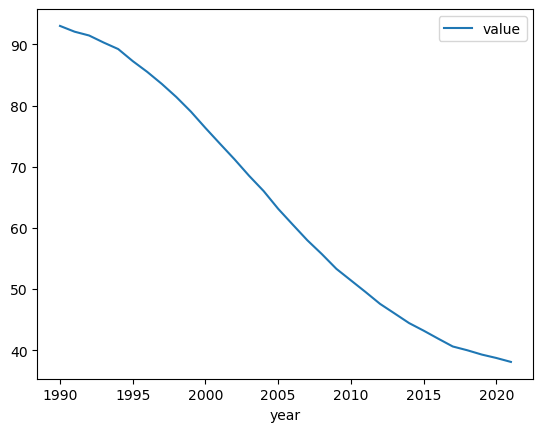

World
 > Is the data stationary ?
Test statistic = -4.829
P-value = 0.000
Critical values :
	1%: -3.7112123008648155 - The data is  stationary with 99% confidence
	5%: -2.981246804733728 - The data is  stationary with 95% confidence
	10%: -2.6300945562130176 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.977
P-value = 0.297
Critical values :
	1%: -3.8092091249999998 - The data is not stationary with 99% confidence
	5%: -3.0216450000000004 - The data is not stationary with 95% confidence
	10%: -2.6507125 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -1.884
P-value = 0.339
Critical values :
	1%: -4.9386902332361515 - The data is not stationary with 99% confidence
	5%: -3.477582857142857 - The data is not stationary with 95% confidence
	10%: -2.8438679591836733 - The data is not stationary with 90% confidence

 > Is the first difference data stationary 

In [12]:
country_name = analysis_df["Country.Name"].unique()

country_name = ["World"]

test_results = []
final_results = []

max_pred = 2100

for x in country_name:
    df = analysis_df[analysis_df["Country.Name"] ==x]
    analysis_agg = df["Location.Type"]
    df = df[["year", "value"]].dropna()
    
    df.set_index("year").plot()
    plt.show()
    
    print(x)
#     print(df.sort_values(by="value", ascending=True))
    d = check_stationarity(df, "value")
    # evaluate parameters
    p_values = [0, 1, 2, 3, 4, 6, 8, 10]
    d_values = range(d, 4)
    q_values = range(0, 4)
    warnings.filterwarnings("ignore")
    results, aics, rmses, X_tests, y_tests, orders, max_tests, forecasts = evaluate_models(df, p_values, d_values, q_values, x, max_pred)
    
    for result, aic, rmse, X_test, y_test, order in zip(results, aics, rmses, X_tests, y_tests, orders):
        summary =result.copy()
        summary["value"] = X_test
        summary["year"] = y_test
        summary["pdq"] = ''.join(map(str, order))
        summary["aic"] = aic
        summary["rmse"] = rmse
        summary["geo"] = x
        test_results.append(summary)

    for forecast, aic, rmse, X_test, y_test, order, max_test in zip(forecasts, aics, rmses, X_tests, y_tests, orders, max_tests):
        forecasted_results =forecast.copy()
        forecasted_results["year"] = pd.date_range(start=f"'{max_test+1}'", end=f"'{max_pred+1}'", freq='A')
        forecasted_results["pdq"] = ''.join(map(str, order))
        forecasted_results["geo"] = x
        final_results.append(forecasted_results)

In [13]:
test_results_output = pd.concat(test_results, ignore_index=True, axis=0)
final_results_output = pd.concat(final_results, ignore_index=True, axis=0)

In [14]:

test_results_output.to_csv("test_results_under5_mortality.csv")
final_results_output.to_csv("final_results_under5_mortality.csv")